In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
#from models.models import V_CNN
from models.models import VAE

In [3]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [4]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# Define data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# Create an instance of the VAE
vae = VAE().to(device)

# Define the loss function and optimizer for VAE
vae_criterion = nn.BCELoss()
vae_optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Training loop for VAE
vae_num_epochs = 30

def vae_loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss
    #recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    recon_loss = F.mse_loss(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')


    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total VAE loss
    vae_loss = recon_loss + kl_loss

    return vae_loss, recon_loss


for epoch in range(vae_num_epochs):
    vae.train()
    train_loss = 0.0
    train_recon_loss = 0.0

    for batch_idx, (images, _) in enumerate(train_loader):
        images = images.to(device)

        vae_optimizer.zero_grad()
        recon_images, mu, logvar = vae(images)
        #vae_loss = vae_loss_function(recon_images, images, mu, logvar)
        vae_loss, vae_recon_loss = vae_loss_function(recon_images.view(-1, 784), images.view(-1, 784), mu, logvar)
        vae_loss.backward()
        vae_optimizer.step()

        train_loss += vae_loss.item()
        train_recon_loss += vae_recon_loss.item()

        if (batch_idx + 1) % 100 == 0:
            #print(f'Epoch [{epoch + 1}/{vae_num_epochs}], Step [{batch_idx + 1}/{len(train_loader)}], '
            #      f'VAE Loss: {vae_loss.item():.4f}')
            print(f'Epoch [{epoch + 1}/{vae_num_epochs}], Step [{batch_idx + 1}/{len(train_loader)}], '
                  f'VAE Loss: {vae_loss.item():.4f}, Recon Loss: {vae_recon_loss.item():.4f}')

    #print(f'Train VAE Loss: {train_loss / len(train_loader):.4f}')
    print(f'Train VAE Loss: {train_loss / len(train_loader):.4f}, Train Recon Loss: {train_recon_loss / len(train_loader):.4f}')

Epoch [1/30], Step [100/938], VAE Loss: 39814.8789, Recon Loss: 39660.6797
Epoch [1/30], Step [200/938], VAE Loss: 36123.2969, Recon Loss: 35175.3359
Epoch [1/30], Step [300/938], VAE Loss: 33362.8203, Recon Loss: 32221.3008
Epoch [1/30], Step [400/938], VAE Loss: 34089.7070, Recon Loss: 32657.1211
Epoch [1/30], Step [500/938], VAE Loss: 33145.0547, Recon Loss: 31538.1348
Epoch [1/30], Step [600/938], VAE Loss: 33552.3945, Recon Loss: 31772.9375
Epoch [1/30], Step [700/938], VAE Loss: 31059.8516, Recon Loss: 29275.6133
Epoch [1/30], Step [800/938], VAE Loss: 32547.1348, Recon Loss: 30737.2070
Epoch [1/30], Step [900/938], VAE Loss: 30251.8496, Recon Loss: 28470.4219
Train VAE Loss: 34458.2500, Train Recon Loss: 33128.0471
Epoch [2/30], Step [100/938], VAE Loss: 30484.0723, Recon Loss: 28593.6211
Epoch [2/30], Step [200/938], VAE Loss: 30203.6270, Recon Loss: 28392.3750
Epoch [2/30], Step [300/938], VAE Loss: 31803.2637, Recon Loss: 29804.0664
Epoch [2/30], Step [400/938], VAE Loss: 301

In [7]:
#################################################################

In [25]:
import torch
import matplotlib.pyplot as plt
import numpy as np


# Example of how to use interpolate_images
image1 = train_dataset[0][0].unsqueeze(0)  # Choose an image from the dataset
image2 = train_dataset[1][0].unsqueeze(0)

In [26]:
# Convert the tensor to a NumPy array and remove the batch dimension
image1_numpy = image1.cpu().detach().numpy()
image1_numpy = image1_numpy.squeeze()

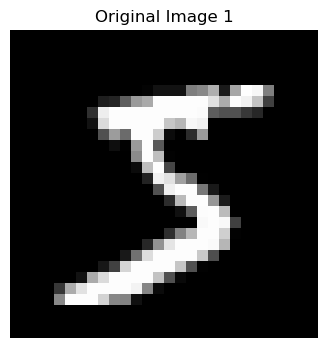

In [27]:
# Plot the original image1
plt.figure(figsize=(4, 4))
plt.imshow(image1_numpy, cmap='gray')
plt.title("Original Image 1")
plt.axis('off')
plt.show()

In [28]:
### Reconstruction procedure
model = VAE()
# Reconstruct the sample image
with torch.no_grad():
    image1 = image1.to(device)
    recon_image1, mu1, logvar1 = vae(image1)

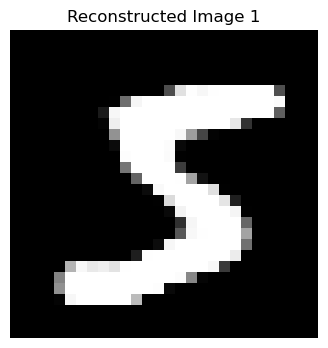

In [57]:
# Plot the Reconstructed image1
plt.figure(figsize=(4, 4))
plt.imshow(recon_image1.cpu().detach().numpy().squeeze(), cmap='gray')
plt.title("Reconstructed Image 1")
plt.axis('off')
plt.show()

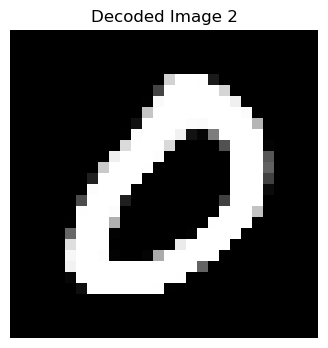

In [71]:
### Encode-Decode Procedure 1
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    z = mu + eps * std
    return z

with torch.no_grad():
    image2 = image2.to(device)
    mu2, logvar2  = vae.encode(image2)
    z2 = reparameterize(mu2, logvar2)
    decoded_image2 = vae.decode(z2)

# Plot the Reconstructed image1
plt.figure(figsize=(4, 4))
plt.imshow(decoded_image2.cpu().detach().numpy().squeeze(), cmap='gray')
plt.title("Decoded Image 2")
plt.axis('off')
plt.show()

In [31]:
### Encode-Decode procedure 2
with torch.no_grad():
    image1 = image1.to(device)
    encoded_image1 = vae.encode(image1)
    decoded_image1 = vae.decode(encoded_image1[0])

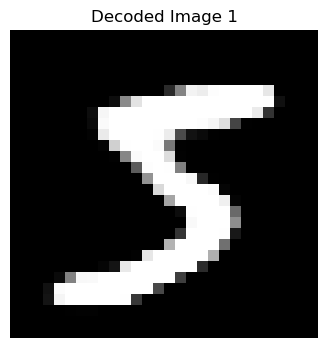

In [56]:
# Plot the Reconstructed image1
plt.figure(figsize=(4, 4))
plt.imshow(decoded_image1.cpu().detach().numpy().squeeze(), cmap='gray')
plt.title("Decoded Image 1")
plt.axis('off')
plt.show()

In [60]:
### Interpolation
# Image interpolation

def interpolate_images(image1, image2, num_steps = 10):
    with torch.no_grad():
        image1 = image1.to(device)
        image2 = image2.to(device)
        # Encode both images
        mu1, logvar1 = vae.encode(image1)
        mu2, logvar2 = vae.encode(image2)

    # Interpolate in latent space
    interpolated_images = []
    for i in range(num_steps):
        t = i / (num_steps - 1)
        latent_interpolated = (1 - t) * mu1 + t * mu2
        reconstructed_interpolated = vae.decode(latent_interpolated)
        interpolated_images.append(reconstructed_interpolated)

    return interpolated_images

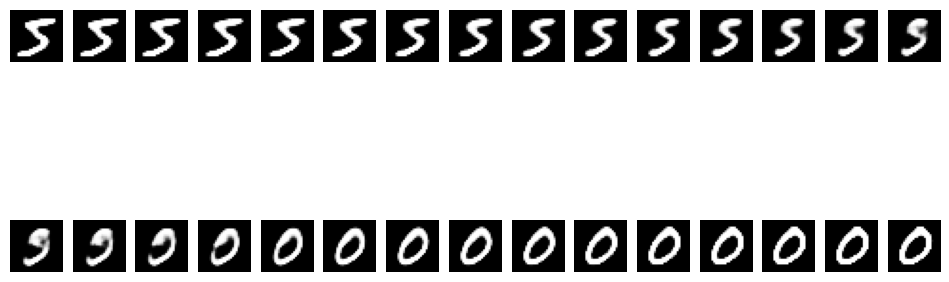

In [67]:
# Example of how to use interpolate_images
image1 = train_dataset[0][0].unsqueeze(0)  # Choose two images from the dataset
image2 = train_dataset[1][0].unsqueeze(0)

num_steps = 30

interpolated_images = interpolate_images(image1, image2, num_steps=num_steps)

# Display the interpolated images
plt.figure(figsize=(12, 5))
for i, image in enumerate(interpolated_images):
    plt.subplot(2, num_steps//2, i+1)
    plt.imshow(image.cpu().detach().numpy().squeeze(),  cmap='gray')
    plt.axis('off')
plt.show()